In [1]:
#importing 
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap
%matplotlib inline



В этом задании вам предстоит научиться работать с географическими данными. В Питоне есть огромное количество библиотек, позволяющих эти данные обрабатывать и визуализировать; выберите ту, которая вам больше понравится. Вам может помочь руководство kaggle по работе с картами: "Семнадцать способов рисовать данные на картах". Смотрите также:

модуль basemap (пример, ещё пример)
плагин gmaps
виджет ipyleaflet (крайне минималистичный пример)
модуль folium

Поскольку мы агрегировали данные по равномерной сетке, можно ожидать, что существенное количество ячеек окажется в районах города, где вызов такси невозможен (реки, заливы, острова, парки). Теоретически ряды, соответствующие таким ячейка, должны состоять из одних нулей, но на практике это может быть не так: устройства, определяющие координаты автомобилей в момент начала поездки, несовершенны и могут ошибаться, показывая, например, что такси находится в середине реки. Чтобы правильно отобрать ячейки, вам понадобится визуализировать их границы на карте и отфильтровать те, из которых поездки на такси невозможны.

Чтобы сдать задание, выполните следующую последовательность действий.

Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.
Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.
Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки).

In [2]:
#Загружаем агрегированные данные, полученные на 1-й неделе и удаляем ненулевые колонки
data5=pd.read_csv('Agg20165.csv',parse_dates=['tpep_pickup_datetime'])


In [3]:
data5.drop('Unnamed: 0', axis=1, inplace=True)
data5.head(3)

region tpep_pickup_datetime  count
0       1  2016-05-01 00:00:00      0
1       1  2016-05-01 01:00:00      0
2       1  2016-05-01 02:00:00      0

In [4]:
#получим суммарное количество поездок из областей
grouper = data5[['region','count']].groupby('region')

In [5]:
res = grouper.sum()

In [6]:
res.reset_index(inplace=True)
res.head()

region  count
0       1      0
1       2      0
2       3      0
3       4      0
4       5      0

In [7]:
# информация о данных
Data=res[res["count"]>0]
Data2=res
print "Пустых областей=", len(res[res["count"]==0]) ,", Областей с поездками=", len(res[res["count"]!=0])


Пустых областей= 1283 , Областей с поездками= 1217


In [8]:
Data[['count']].describe().transpose()

count        mean          std  min  25%   50%   75%       max
count  1217.0  9553.42728  53300.29235  1.0  2.0  10.0  76.0  638799.0

In [9]:
#загрузим данные по областям , их идентификаторам и координатам
reg=pd.read_csv('regions.csv', sep=';')
reg.head()

region      west       east      south      north
0       1 -74.25559 -74.244478  40.496120  40.504508
1       2 -74.25559 -74.244478  40.504508  40.512896
2       3 -74.25559 -74.244478  40.512896  40.521285
3       4 -74.25559 -74.244478  40.521285  40.529673
4       5 -74.25559 -74.244478  40.529673  40.538061

In [10]:
#Получим координаты сетки областей 
lon_list= sorted(list(set(np.concatenate((reg.west.values,reg.east.values),axis=0))))
lat_list= sorted( list(set(np.concatenate((reg.south.values,reg.north.values),axis=0))))


In [11]:
# проведем join данных: агрегированные данные, область и координаты
MD=pd.merge(Data, reg, on='region', how='left')
MD2=pd.merge(Data2, reg, on='region', how='left')

In [12]:
MD.head()

region  count      west       east      south      north
0      15      1 -74.25559 -74.244478  40.613555  40.621943
1      16      1 -74.25559 -74.244478  40.621943  40.630331
2      25      1 -74.25559 -74.244478  40.697437  40.705825
3      27      1 -74.25559 -74.244478  40.714213  40.722601
4      32     19 -74.25559 -74.244478  40.756154  40.764542

In [15]:
# вспопогательные переменные и функции. координыты центров областей и функция возращающая количество поездок
lons = lon_list
lats = lat_list
# координаты центров областей
lons_c = sorted(list(set((MD2['west'].values+MD2[ 'east'].values)/2.0)))
lats_c = sorted(list(set((MD2['south'].values+MD2[ 'north'].values)/2.0)))

#определение количества поездок из областей по координатам центра или порядковым номерам
def r(lon,lat):
    return (MD2[(MD2.west<=lon) & (MD2.east>=lon) & (MD2.south<=lat) & (MD2.north>=lat)]['count'].iloc[0])
    
#(reg['south']<=40.748817) & (reg['north']>=40.748817) & (reg['west']<=-73.985428) & (reg['east']>=-73.985428)

def ri(x,y):
    lon=lons_c[x]
    lat=lats_c[y]
    return r(lon,lat)


 Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты

координаты Эмпайр стейт билдинг 40.74778, -73.98583
координаты Статуи Свободы       40.689166676667, -74.044583343333

In [16]:
# количество поездок из областей
c_min=1
c_max= MD2.iloc[:, 1].max()


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-74.25559,40.49612,-73.70001,40.91553&bboxSR=4326&imageSR=4326&size=1500,1132&dpi=96&format=png32&f=image


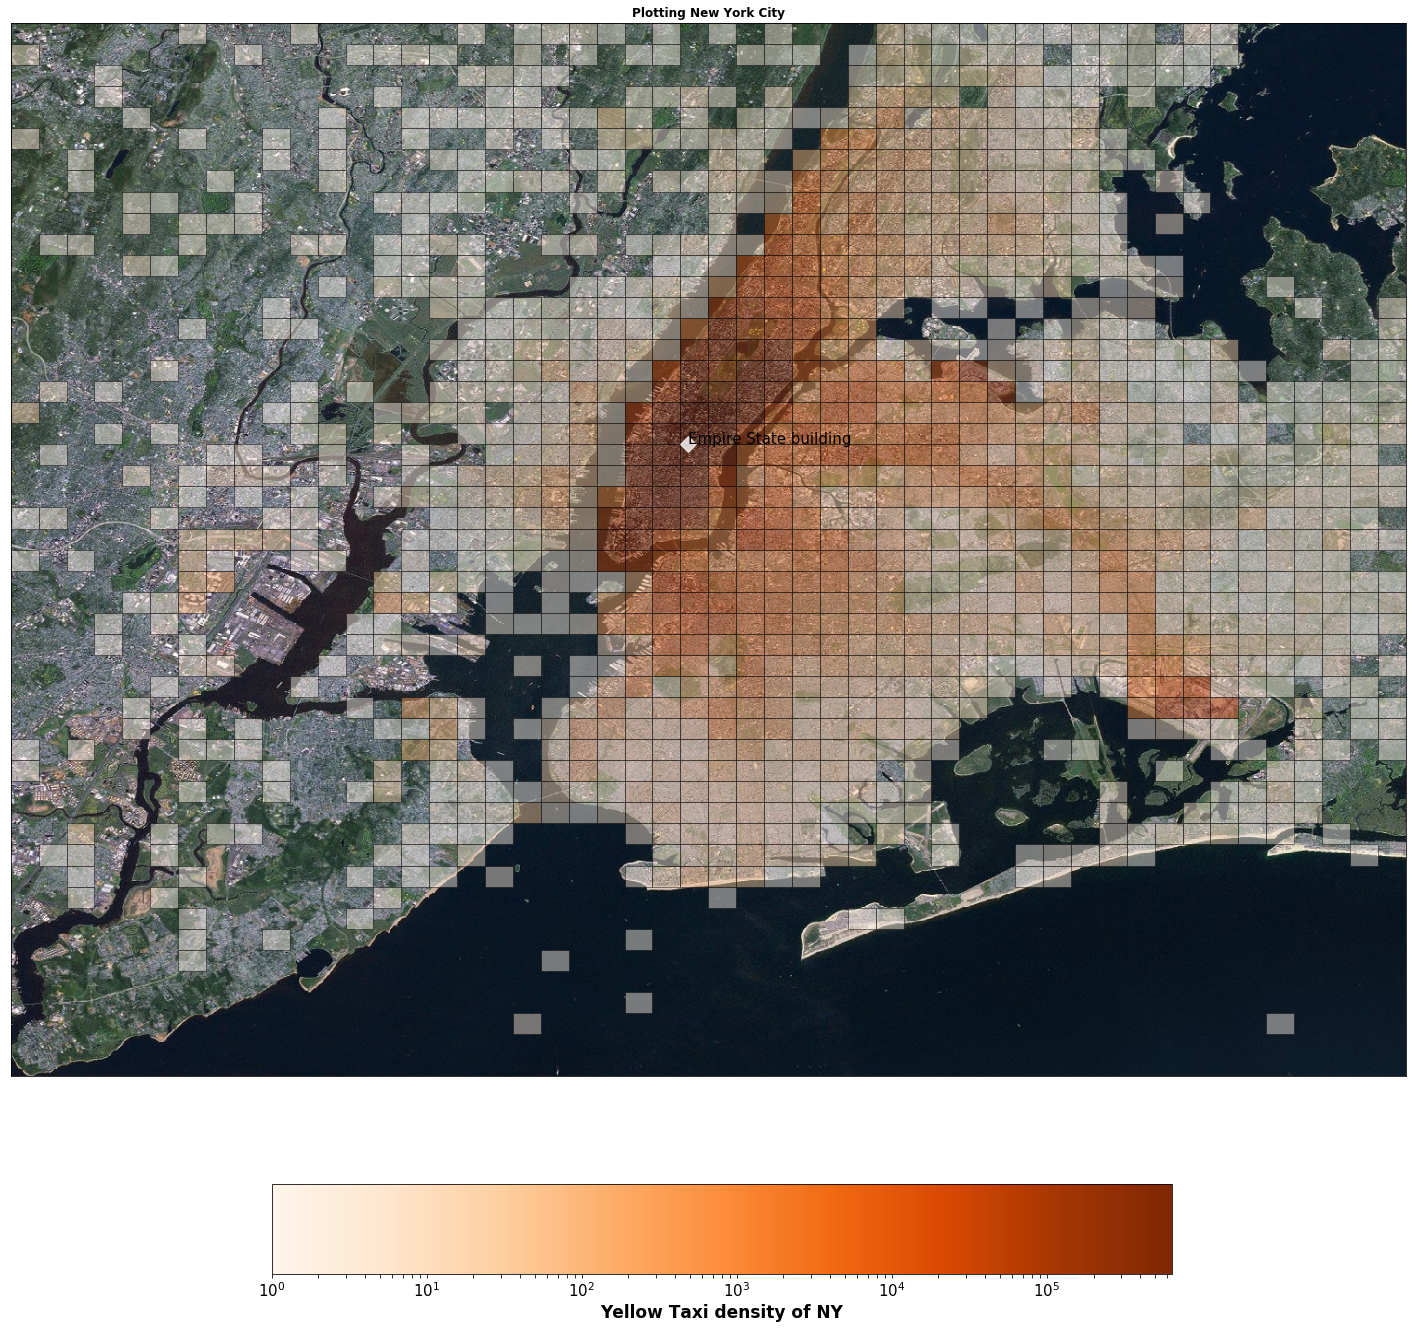

In [18]:
#отобразим на статичной карте полученную информацию
import math
import matplotlib 
from matplotlib.cm import ScalarMappable
#границы Нью-Йорка
LOW_LEFT_CORNR_LONGITUDE = -74.25559
LOW_LEFT_CORNER_LATITUDE = 40.49612
UP_RIGHT_CORNER_LONGITUDE = -73.70001
UP_RIGHT_CORNER_LATITUDE = 40.91553
LON_C=(LOW_LEFT_CORNR_LONGITUDE+UP_RIGHT_CORNER_LONGITUDE)/2.0
LAT_C=(LOW_LEFT_CORNER_LATITUDE+UP_RIGHT_CORNER_LATITUDE)/2.0

# Create the Basemap
fig = plt.figure(figsize=(25,25))
m = Basemap(llcrnrlon=LOW_LEFT_CORNR_LONGITUDE,
            llcrnrlat=LOW_LEFT_CORNER_LATITUDE,
            urcrnrlon=UP_RIGHT_CORNER_LONGITUDE,
            urcrnrlat=UP_RIGHT_CORNER_LATITUDE,
#             resolution='h',
            area_thresh=0.1)

m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)

# цвет
#norm = matplotlib.colors.Normalize(vmin=c_min, vmax=c_max)
norm = matplotlib.colors.LogNorm(vmin=c_min, vmax=c_max)
cmap = cm.Oranges
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)




#закрасим области
for ii,xi in enumerate(lons_c):
    for jj,yi in enumerate(lats_c):
        if(r(xi,yi)>0):
            xxi,yyi=m(xi,yi)
            x1,y1 = m(lons[ii],lats[jj])
            x2,y2 = m(lons[ii],lats[jj+1])
            x3,y3 = m(lons[ii+1],lats[jj+1])
            x4,y4 = m(lons[ii+1],lats[jj])
            poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor=mapper.to_rgba((r(xi,yi))),alpha=0.45,linewidth=1,edgecolor='k')
            plt.gca().add_patch(poly)


# Обозначим Empire State building
lat=40.74778
lon= -73.98583
x,y=m(lon,lat)
m.plot(x, y, marker='D',color='w', markersize=12,alpha=0.8)
plt.text(x, y, 'Empire State building', size=15)
plt.title('Plotting New York City',weight='bold')

#Колорбар
cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
cb = matplotlib.colorbar.ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
cb.ax.set_xlabel('Yellow Taxi density of NY',weight='bold',size=17)
cb.ax.tick_params(labelsize=15)

plt.show()



In [19]:
#Вспомогательные функции и информация для второй части задания.
# Вычислим среднее количество поездок в час
res2=grouper.mean()
res2.reset_index(inplace=True)
res2.head()
print "Областей при среднем количестве поездок не менее 5 в час:", res2[res2['count']>=5].count()[0]

MD3=pd.merge(res2, reg, on='region', how='left')

def r2(lon,lat):
    return (MD3[(MD3.west<=lon) & (MD3.east>=lon) & (MD3.south<=lat) & (MD3.north>=lat)]['count'].iloc[0])

print "Максимальное среднее кол-во поездок в час ",  res2['count'].max()

Областей при среднем количестве поездок не менее 5 в час: 102
Максимальное среднее кол-во поездок в час  858.600806452


In [20]:
# цветовая гамма
def getColor(d):
    s = '#FFEDA0'
    if d > 800 : return '#bd0026' 
    if d > 500: return '#f03b20' 
    if d > 100: return'#fd8d3c' 
    if d > 50: return '#fecc5c'
    if d > 5: return'#ffffb2' 
    return s


In [21]:
# отобразим интерактивную карту
import folium
map_2 = folium.Map(location=[40.705825, -73.9778], zoom_start=11,tiles='Stamen Terrain')
# точка Статуи свободы
folium.Marker(location=[40.689166676667, -74.044583343333], popup='Statue of Liberty').add_to(map_2)

for ii,xi in enumerate(lons_c):
    for jj,yi in enumerate(lats_c):
        if(r2(xi,yi)>5):
            x1,y1 = lons[ii],lats[jj]
            x2,y2 = lons[ii],lats[jj+1]
            x3,y3 = lons[ii+1],lats[jj+1]
            x4,y4 = lons[ii+1],lats[jj]
            folium.PolyLine(locations=[[y1,x1],[y2,x2],[y3,x3],[y4,x4],[y1,x1]], color='black', weight=1).add_to(map_2)
            folium.CircleMarker([yi, xi], radius=8, popup=str(int(r2(xi,yi))), color=getColor(r2(xi,yi)),fill_color=getColor(r2(xi,yi)),fill_opacity=0.3).add_to(map_2)
map_2

In [23]:
# отобразим еще один вариант интерактивной карты 
from folium.plugins import HeatMap
map_3 = folium.Map(location=[40.705825, -73.9778], zoom_start=11)
folium.Marker(location=[40.689166676667, -74.044583343333], popup='Statue of Liberty').add_to(map_3)


data=[]
for ii,xi in enumerate(lons_c):
    for jj,yi in enumerate(lats_c):
        x1,y1 = lons[ii],lats[jj]
        x2,y2 = lons[ii],lats[jj+1]
        x3,y3 = lons[ii+1],lats[jj+1]
        x4,y4 = lons[ii+1],lats[jj]
        folium.PolyLine(locations=[[y1,x1],[y2,x2],[y3,x3],[y4,x4],[y1,x1]], color='black', weight=0.1).add_to(map_3)
        if(r2(xi,yi)>5):
             data.append([yi,xi,r2(xi,yi)])
            
#            folium.CircleMarker([yi, xi], radius=8, popup=str(r(xi,yi)), color=getColor(r2(xi,yi)),fill_color=getColor(r2(xi,yi)),fill_opacity=0.3).add_to(map_2)
#            folium.CircleMarker([yi, xi], radius=8, popup=str(r(xi,yi)), color=getColor(r(xi,yi)),fill_color=r(xi,yi),fill_opacity=0.3,colormap=cm1).add_to(map_2)
HeatMap(data, min_opacity=0.5, max_val=859).add_to(map_3)
map_3


